# Quality Control App

This app iterates through the existing videos in SurvAI's [var_data](https://app.supabase.com/project/gcqjfsaovvyvuedsquli/editor/19455?sort=index%3Adesc) database and allows you to update the label, time_start, time_end and clarity_level for each.

### Running the app
1. `pip install notebook` in your desired environment, if you haven't already.
2. In a terminal, cd to the appropriate directory and enter `jupyter notebook quality_control.ipynb`
3. Run the cells in order once jupyter notebook is launched.

### Features
- The third cell will prompt you for a specific label that you wish to review. This will filter the database and create a list of clips that match the specified label.

- Using 'eq' functions, you can filter through whatever combination of data constraints are desired. In its current form, the list of clips will include videos that have a clarity_level 'equal to' none and a label 'equal to' the label you specify. You can add or take away as many of these constraints as you want. Eq functions can be utilized by adding, deleting or modifying the existing line of code in cell 3 that creates the list of clips. Below are specific examples of how to use the eq functions.

    - examples:

        1. A list of videos that have a 'clarity_level' of 'hard' --> eq('clarity_level', 'hard')

        2. A list of videos that have a 'youtube_id' of 'R8vVsPCwKY4' --> eq('youtube_id', 'R8vVsPCwKY4')
        
        3. A list of videos that have a 'clarity_level' of 'hard' AND a 'youtube_id' of 'R8vVsPCwKY4' --> eq('clarity_level', 'hard').eq('youtube_id', 'R8vVsPCwKY4')

In [1]:
from IPython.display import HTML, clear_output, YouTubeVideo, IFrame
import time
import os
from supabase import create_client
import datetime
from datetime import date
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [2]:
# Connect to database
url = os.environ.get("SUPABASE_URL")
key = os.environ.get("SUPABASE_KEY")
email = os.environ.get("EMAIL")
password = os.environ.get("PASSWORD")
client = create_client(url, key)
user = client.auth.sign_in(email=email, password=password)

In [ ]:
def convert_time(time):
    '''function to convert total seconds to hours, minutes and seconds'''
    return str(datetime.timedelta(seconds=time))

clarity_list = ['easy', 'medium', 'hard', 'bad']

labels = ['brawling', 'crowd', 'restraining', 'running', 'person_on_ground', 'nothing', 
                'spray', 'striking', 'throwing', 'person_pointing', 'advancing', 'aiming']

label = input('enter the label you want to review: ')

# create list of clips with matching labels where clarity_level is none
clips = list(client.table('var_data').select('clarity_level', 'id', 'time_start', 'time_end', 'label').eq('clarity_level', 'none').eq('label', label).execute())[0][1]
clips

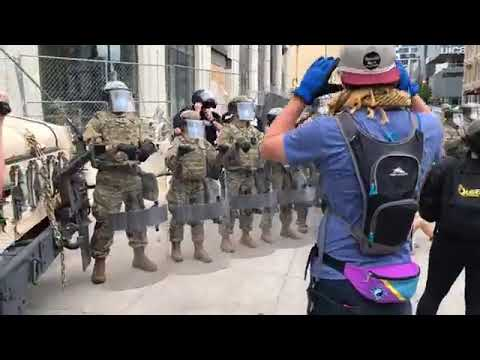

index:3/210 , id: 4Hn2FjmhP4Q19 , label: person_pointing , timestamp: 0:22:32 - 0:22:36 , clarity level: none
r = restart vid, t = change timestamp, cl = change clarity_level, n = next vid, p = previous vid, exit = exitexit


In [4]:
break_out = False
index = 0

while True:

    id = clips[index]['id']
    start = clips[index]['time_start']
    end = clips[index]['time_end']
    clarity = clips[index]['clarity_level']

    adjusting_annot = True
   

    if break_out == True:
        break

    if clarity != 'none':
        untagged = False
    else:
        untagged = True 


    while adjusting_annot == True:

        # play video
        clear_output(wait=True) 
        vid = YouTubeVideo(id[0:11], start=start, end=end, allow_autoplay=True, width=560, height=315)
        display(vid)

        # print data
        print(f'index:{index}/{len(clips)}', ', id:', id,', label:', label, 
                f', timestamp: {convert_time(start)} - {convert_time(end)}', ', clarity level:', clarity)

        data = input('r = restart vid, t = change timestamp, cl = change clarity_level, n = next vid, p = previous vid, exit = exit')


        # restart video
        if data == 'r':
            continue
        

        # change start and/or end time
        if data == 't':
            time_stamp = input('enter new timestamp (2:23, 2:34): ')
            
            try:
                # convert time to total seconds
                start = (int(time_stamp.split(',')[0].split(':')[0]) * 60) + int(time_stamp.split(',')[0].split(':')[1])
                end = (int(time_stamp.split(',')[1].split(':')[0]) * 60) + int(time_stamp.split(',')[1].split(':')[1])

                # insert new data into var_data
                client.table('var_data').update({'time_start': start, 'time_end': end}).eq('id', id).execute()

                # update data in list
                clips[index]['time_start'] = start
                clips[index]['time_end'] = end

            except:
                print('incorrect entry, try again')
                time.sleep(2)


        # change label
        if data == 'l':
            label = input('enter label: ')

            if label in labels:
                client.table('var_data').update({'label': label}).eq('id', id).execute()
                clips[index]['label'] = label
            else:
                print('invalid input, try again')
                continue
            

        # update clarity_level
        if data == 'cl':
            clarity = input('enter clarity_level (easy, medium, hard or bad): ')

            # insert new clarity_level to var_data
            if clarity in clarity_list:
                client.table('var_data').update({'clarity_level': clarity}).eq('id', id).execute()
                clips[index]['clarity_level'] = clarity
                untagged = False
            else:
                print('invalid input, try again')
                continue

        
        # go to next video
        if data == 'n':
            if untagged == True:
                print('no clarity_level tag on video')
                time.sleep(3)
                continue
            else:
                # add the date to the 'reviewed' column
                client.table('var_data').update({'reviewed': str(date.today())}).eq('id', id).execute()
                index += 1
                adjusting_annot = False    

        
        # go to previous video
        if data == 'p':
            index -= 1
            adjusting_annot = False
            break

        # exit program
        if data == 'exit':
            break_out = True
            adjusting_annot = False
            break
